In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *
from tomopt.plotting import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-5787166f89b9>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


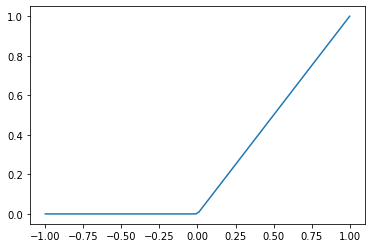

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]),

# Data

In [7]:
from tomopt.optimisation.data.passives import AbsPassiveGenerator
from typing import *
from random import shuffle

class FixedBlockPassiveGenerator(AbsPassiveGenerator):
    def generate(self) -> Callable[..., Tensor]:
        shuffle(self.materials)
        
        def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
            rad_length = torch.ones(list((lw/size).long()))*X0[self.materials[0]]
            if z > 0.5: rad_length[...] = X0[self.materials[1]]
            return rad_length
        
        return arb_rad_length

In [9]:
from lumin.nn.data.fold_yielder import FoldYielder

class ScatterYielder(FoldYielder):
    def __init__(self, volume:Volume, passive_generator:AbsPassiveGenerator, mu_bs:int, n_volumes_per_fold:int, targ_as_class:bool):
        self.cont_feats,self.cat_feats,self.input_pipe,self.output_pipe = [],[],None,None
        self.yield_matrix,self.matrix_pipe = True,None
        self.augmented,self.aug_mult,self.train_time_aug,self.test_time_aug = False,0,False,False
        self.input_feats = self.cont_feats + self.cat_feats
        self.orig_cont_feats,self.orig_cat_feat,self._ignore_feats = self.cont_feats,self.cat_feats,[]
        
        self.volume,self.passive_generator,self.mu_bs = volume,passive_generator,mu_bs
        self.voxel_centres = self._build_centres()
        self.targ_as_class = targ_as_class
        if self.targ_as_class:
            self.class2id = {m:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2class = {i:m for i,m in enumerate(self.passive_generator.materials)}
            self.x02id = {X0[m]:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2x0 = {i:X0[m] for i,m in enumerate(self.passive_generator.materials)}
                
        self.n_volumes_per_fold = n_volumes_per_fold
        self.n_voxels = int(len(self.volume.get_passives())*(self.volume.lw/self.volume.passive_size).prod().item())
        self.n_folds = 10
        self.has_matrix = True
        self.fld_szs = {i:self.n_volumes_per_fold*self.n_voxels for i in range(self.n_folds)}
        
        self.targ_feats = ["X0"]
        self.matrix_feats = {'present_feats': ["dtheta_x", "dtheta_y", "dx", "dy", "pred_x0", "dpoca_x", "dpoca_y", "dpoca_z", "dpoca_r"],
                             'vecs': [f'mu_{i}' for i in range(self.mu_bs)], 'missing': [], 'row_wise': True}
        self.matrix_feats['feats_per_vec'] = len(self.matrix_feats['present_feats']), 
        self.matrix_feats['shape'] = (self.mu_bs, self.matrix_feats['feats_per_vec'])
        self.matrix_is_sparse = False
        self.matrix_shape = self.matrix_feats['shape']
        
    def _build_centres(self) -> Tensor:
        bounds = (
            self.volume.passive_size
            * np.mgrid[
                round(self.volume.get_passive_z_range()[0].detach().cpu().numpy()[0] / self.volume.passive_size) : round(
                      self.volume.get_passive_z_range()[1].detach().cpu().numpy()[0] / self.volume.passive_size
                ) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[0] / self.volume.passive_size) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[1] / self.volume.passive_size) : 1,
            ]
        )
#         bounds[0] = np.flip(bounds[0])  # z is reversed
        voxel_centres = torch.tensor(bounds.reshape(3, -1).transpose(-1, -2)) + (self.volume.passive_size/2)
        return voxel_centres[:,None].repeat_interleave(self.mu_bs, dim=1)
        
    def generate_data(self) -> Dict[str, np.ndarray]:
        inputs,targets = [],[]
        for _ in range(self.n_volumes_per_fold):
            #Scatter generation
            muons = MuonBatch(generate_batch(self.mu_bs), self.volume.h, device=self.volume.device)
            self.volume.load_rad_length(self.passive_generator.generate())
            self.volume(muons)
            sb = GenScatterBatch(muons, self.volume)
            
            # x0 prediction
            mom = muons.reco_mom
            dtheta = sb.dtheta
            theta_xy_in = sb.theta_in
            theta_xy_out = sb.theta_out
            theta2 = dtheta.pow(2).sum(1)
            n_x0 = 0.5 * theta2 * ((mom / SCATTER_COEF_A) ** 2)
            theta_in = theta_xy_in.pow(2).sum(1).sqrt()
            theta_out = theta_xy_out.pow(2).sum(1).sqrt()
            cos_theta_in = torch.cos(theta_in)
            cos_theta_out = torch.cos(theta_out)
            cos_mean = (cos_theta_in + cos_theta_out) / 2
            pred = self.volume.passive_size / (n_x0 * cos_mean)
            
            #Data creation
            data = torch.cat((sb.dtheta, sb.dxy, pred[:,None], sb.location), dim=-1).detach()
            data = data[None,:].repeat_interleave(len(self.voxel_centres), dim=0).clone()
            data[:,:,-3:] -= self.voxel_centres
            data = torch.cat((data,data[:,:,-3:].square().sum(-1, keepdim=True).sqrt()), dim=-1)  # dR
            
            
            # Sort by dR
            idxs = data[:,:,-1].argsort()
            i = np.arange(data.shape[0])[:,None]
            data = data[i,idxs]
            
            inputs.append(data)
            targets.append(self.volume.get_rad_cube().flatten())
        
        inputs = torch.cat(inputs, dim=0).detach().cpu().numpy()
        targets = torch.cat(targets, dim=0).detach().cpu().numpy()[:,None]
        if self.targ_as_class:
            for m in self.passive_generator.materials:
                targets[targets == X0[m]] = self.class2id[m]
            targets = targets.astype(int)
        return {'inputs':(np.zeros((len(inputs),0)),inputs),'targets':targets}
        
    def get_fold(self, idx:int) -> Dict[str,np.ndarray]:
        return self.generate_data()

In [10]:
sy = ScatterYielder(volume=volume, passive_generator=FixedBlockPassiveGenerator(materials=['beryllium', 'lead']), mu_bs=100, n_volumes_per_fold=2, targ_as_class=True)

In [11]:
sy.n_voxels

600

In [12]:
fold = sy[0]
fold['inputs'][1].shape,fold['targets'].shape

((1200, 100, 9), (1200, 1))

In [13]:
fold['targets'][0]

array([0])

# Classifier

In [16]:
from lumin.nn.models.blocks.head import GNNHead, GraphCollapser
from lumin.nn.models.blocks.gnn_blocks import GravNet
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.blocks.tail import ClassRegMulti

from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.layers.batchnorms import RunningBatchNorm1d
from lumin.optimisation.hyper_param import lr_find

head = partial(GNNHead, vecs=sy.matrix_feats['vecs'], feats_per_vec=sy.matrix_feats['present_feats'], use_in_bn=True, bn_class=RunningBatchNorm1d,
               extractor=partial(GravNet,
                                 cat_means=True,
                                 f_slr_depth=3,
                                 n_s=4,
                                 n_lr=22,
                                 k=50,
                                 f_out_depth=1,
                                 n_out=[48],
                                 act='swish',
                                 bn=False),
               collapser=partial(GraphCollapser,
                                 flatten=False,
                                 f_final_outs=[40],
                                 act='swish'))

body = partial(FullyConnected, depth=3, width=50, act='swish')
opt_args = {'opt':'adam', 'eps':1e-08}
model_builder = ModelBuilder('class', cont_feats=sy.matrix_feats['present_feats'], n_out=1, 
                             opt_args=opt_args, body=body, head=head)
print(Model(model_builder))

Inputs:
9 Continuous: ['dtheta_x', 'dtheta_y', 'dx', 'dy', 'pred_x0', 'dpoca_x', 'dpoca_y', 'dpoca_z', 'dpoca_r']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): GNNHead(
    (bn): LCBatchNorm1d(
      (bn): RunningBatchNorm1d()
    )
    (extractor): GravNet(
      (grav_layers): ModuleList(
        (0): GravNetLayer(
          (f_slr): Sequential(
            (0): Sequential(
              (0): Linear(in_features=18, out_features=52, bias=True)
              (1): Swish()
            )
            (1): Sequential(
              (0): Linear(in_features=52, out_features=52, bias=True)
              (1): Swish()
            )
            (2): Sequential(
              (0): Linear(in_features=52, out_features=26, bias=True)
              (1): Swish()
            )
          )
          (f_out): Sequential(
            (0): Sequential(
              (0): Linear(in_features=62

LR finder took 11.166s 


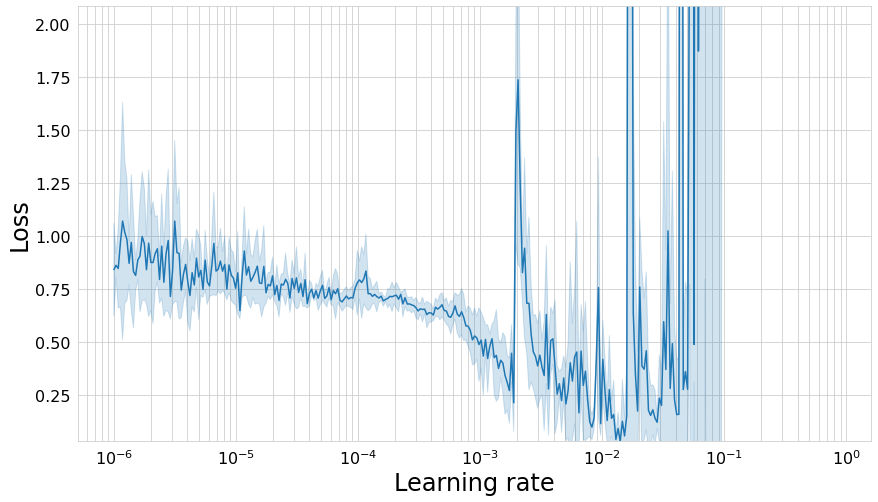

In [17]:
lr_finder = lr_find(sy, model_builder, bs=32, lr_bounds=[1e-6,1e0], n_repeats=3)

In [19]:
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from lumin.nn.metrics.class_eval import RocAucScore
from functools import partial

cb_partials = [partial(OneCycle, lengths=[5, 10],lr_range=[1e-5, 1e-3], mom_range=[0.85, 0.95], interp='cosine')]
metric_partials = (RocAucScore)

Training model 1 / 1, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


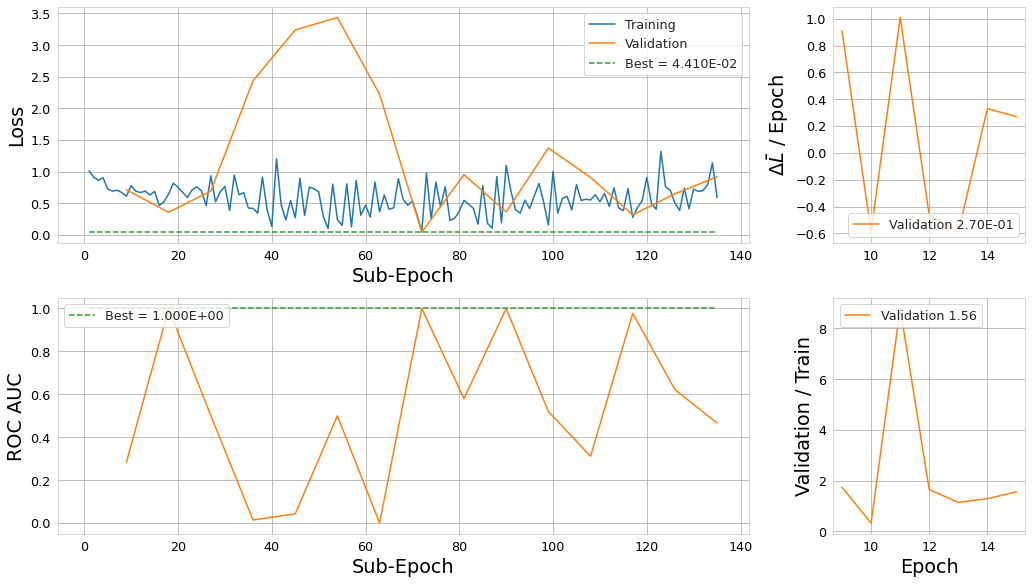

Loading best model with metric value -1.000E+00
Model took 85.080s

Scores are: {'loss': 0.04409954682801311, 'ROC AUC': 1.0}

______________________________________
Training finished
Cross-validation took 85.173s 


<Figure size 1024x576 with 0 Axes>

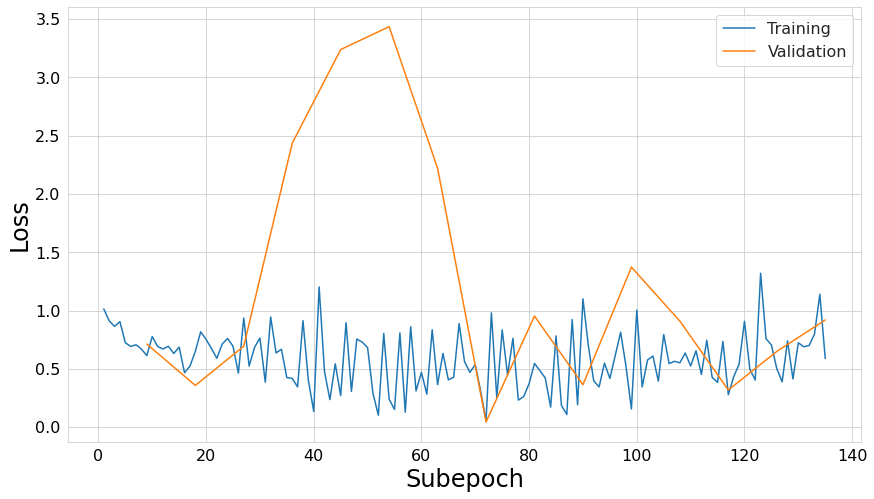

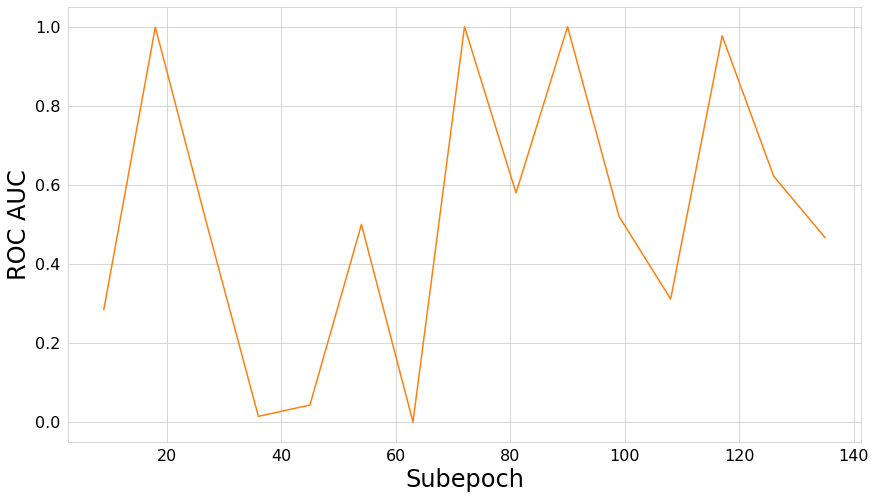

Mean loss = 0.04409954682801311±0.0
Mean ROC AUC = 1.0±0.0
______________________________________



In [20]:
from lumin.nn.training.train import train_models
_ = train_models(sy, n_models=1,
                 model_builder=model_builder,
                 bs=32,
                 cb_partials=cb_partials,
                 metric_partials=metric_partials,
                 n_epochs=15,
                 bulk_move=False)

In [21]:
model = Model.from_save('train_weights/model_id_0/best.h5', model_builder)

In [22]:
data = sy[0]

In [23]:
pred = model.predict(data['inputs'])

In [24]:
pred

array([[1.1860630e-03],
       [6.9983659e-04],
       [4.3685985e-04],
       ...,
       [9.9955875e-01],
       [9.9956149e-01],
       [9.9954176e-01]], dtype=float32)

In [25]:
data['inputs'][1][0,0]

array([ 0.00966764,  0.01490126, -0.00044484, -0.00029263,  0.00472284,
       -0.01581396,  0.0640966 ,  0.2720466 ,  0.2799425 ], dtype=float32)

In [26]:
# pred_class = pred.argmax(-1)
pred_class = pred > 0.5

In [27]:
pred_class

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [28]:
targs = data['targets'].flatten()

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
confusion_matrix(targs, pred_class)

array([[400, 200],
       [300, 300]])

In [31]:
targs

array([1, 1, 1, ..., 1, 1, 1])

In [32]:
from lumin.plotting.results import plot_roc, plot_binary_class_pred
from lumin.plotting.plot_settings import PlotSettings

In [33]:
import pandas as pd

In [34]:
df = pd.DataFrame({'pred':pred.squeeze(), 'gen_target':targs})

In [35]:
plot_settings = PlotSettings(targ2class={0:sy.passive_generator.materials[0], 1:sy.passive_generator.materials[1]})

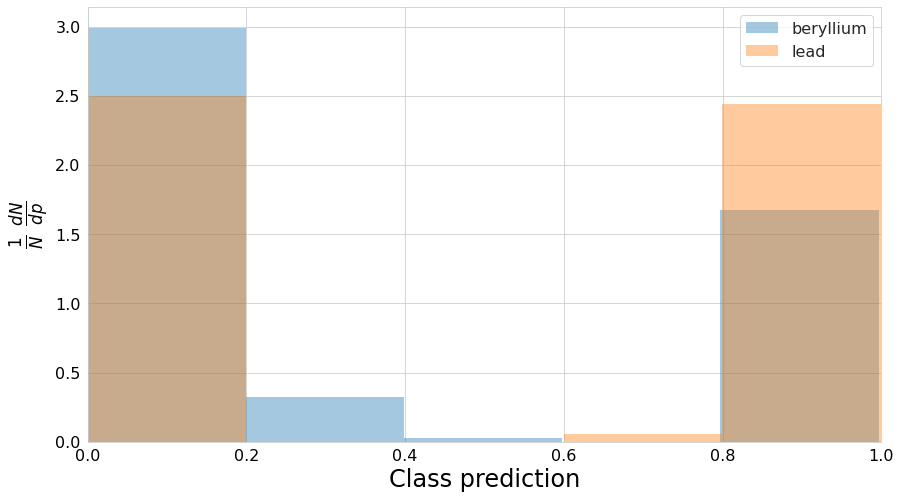

In [36]:
plot_binary_class_pred(df, settings=plot_settings)

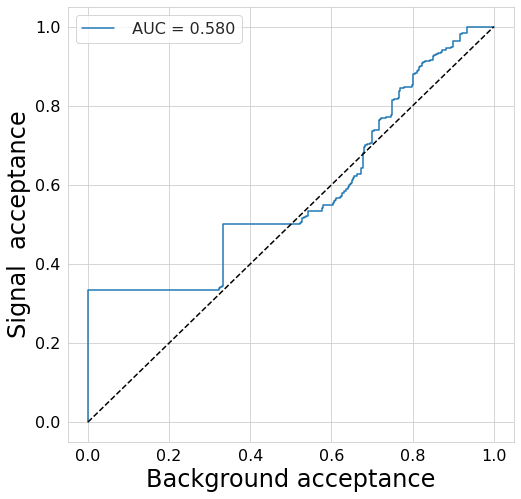

{'': 0.5798749999999999}

In [37]:
plot_roc(df)